## NNSight

In [1]:
%%capture --no-stderr
!pip install numpy nnsight torch scikit-learn

In [2]:
import gc
import os

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nnsight import LanguageModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datasets import concatenate_datasets, load_dataset
from tqdm import tqdm
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [3]:
model = LanguageModel("google/gemma-3-270m-it", device_map="auto", dispatch=True)

LAYER = 8

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

### 1. Record activations on the dataset.

In [4]:
ds_harmful = load_dataset("bench-llm/or-bench", "or-bench-toxic", split="train")
ds_harmful = ds_harmful.shuffle(seed=0)
ds_harmful = ds_harmful.select(range(300))
ds_harmful = ds_harmful.select_columns(["prompt"])
ds_harmful = ds_harmful.map(lambda x: {"label": 1})

ds_harmless = load_dataset("bench-llm/or-bench", "or-bench-80k", split="train")
ds_harmless = ds_harmless.shuffle(seed=0)
ds_harmless = ds_harmless.select(range(len(ds_harmful)))
ds_harmless = ds_harmless.select_columns(["prompt"])
ds_harmless = ds_harmless.map(lambda x: {"label": 0})

ds_combined = concatenate_datasets([ds_harmful, ds_harmless])

README.md: 0.00B [00:00, ?B/s]

or-bench-toxic.csv:   0%|          | 0.00/64.7k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

or-bench-80k.csv:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
saved = []
BATCH_SIZE = 16  # Process in batches to prevent OOM

prompts = ds_combined["prompt"]

for i in tqdm(range(0, len(prompts), BATCH_SIZE)):
    batch_prompts = prompts[i : i + BATCH_SIZE]
    batch_saved = []

    # Trace a small batch of prompts
    with model.trace() as tracer:
        for t in batch_prompts:
            with tracer.invoke(t):
                # Save the hidden state at the last token
                h = model.model.layers[LAYER].output[0][0, -1, :].save()
                batch_saved.append(h)

    # Move results to CPU immediately to free GPU memory
    for h in batch_saved:
        saved.append(h.detach().cpu())

    # Cleanup
    del batch_saved
    torch.cuda.empty_cache()

H = torch.stack(saved).numpy()  # [N, d_model]

100%|██████████| 38/38 [00:13<00:00,  2.74it/s]


In [7]:
gc.collect()
torch.cuda.empty_cache()

### 2. Train a linear probe on the activations.

In [8]:
ds_combined = ds_combined.with_format("numpy")

Xtr, Xte, ytr, yte = train_test_split(H,
                                      [int(label) for label in ds_combined["label"]],
                                      test_size=0.2,
                                      stratify=[int(label) for label in ds_combined["label"]],
                                      random_state=0)

clf = LogisticRegression(max_iter=2000)
clf.fit(Xtr, ytr)

logits = clf.decision_function(Xte)

print("Probe Accuracy (Test):", clf.score(Xte, yte))

w = clf.coef_[0]  # [d_model]
b = clf.intercept_

Probe Accuracy (Test): 0.8833333333333333


In [9]:
def plot_kde(positive_scores, negative_scores):
    plt.figure(figsize=(10, 6))
    # Plotting positive scores
    sns.kdeplot(positive_scores, fill=True, bw_adjust=0.1,  # specify bandwidth here
                color='darkblue', label='Positive')
    # Plotting negative scores
    sns.kdeplot(negative_scores, fill=True, bw_adjust=0.1,  # specify bandwidth here
                color='darkred', label='Negative')
    # Adding legend, title, and labels
    plt.legend(prop={'size': 16}, title='Scores')
    plt.title('Logit Distribution for Positive and Negative Examples')
    plt.xlabel('Logit')
    plt.ylabel('Density')
    plt.show()

In [10]:
logits_for_harmful = [logits[i] for i in range(len(yte)) if yte[i] == 1]
logits_for_harmless = [logits[i] for i in range(len(yte)) if yte[i] == 0]

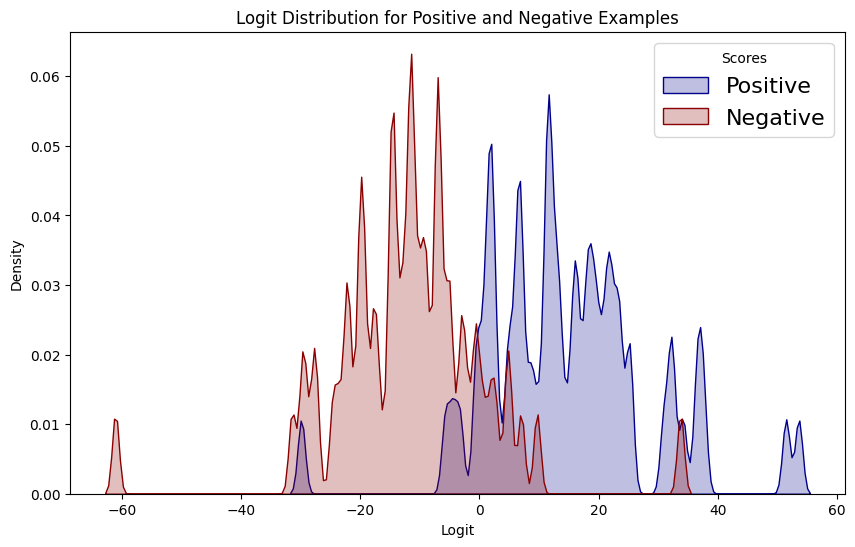

In [11]:
plot_kde(logits_for_harmful, logits_for_harmless)

### 3. Quantize weights, bias, and activations.

In [12]:
# Symmetric int16 Quantization of Weights

Sw = 10_000

quantized_w = np.clip(np.round(w * Sw),
                      -np.iinfo(np.int16).max,
                      np.iinfo(np.int16).max).astype(np.int16)

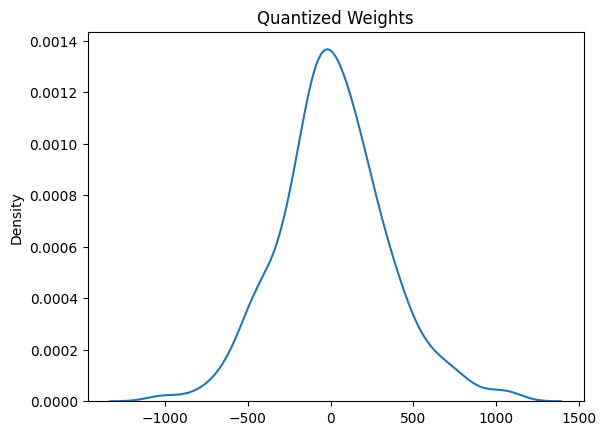

In [13]:
sns.kdeplot(quantized_w)
plt.title("Quantized Weights")
plt.show()

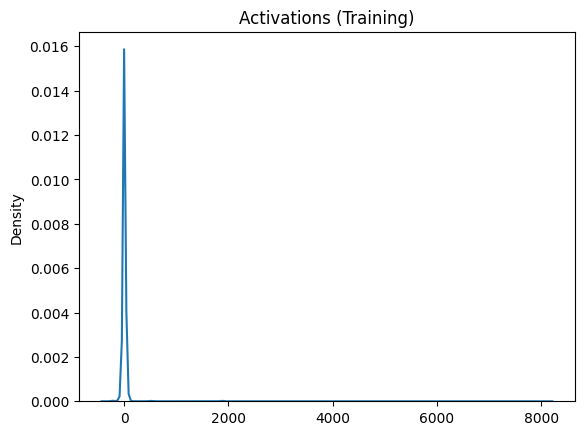

In [14]:
sns.kdeplot(np.hstack(Xtr))
plt.title("Activations (Training)")
plt.show()

In [15]:
# Quantization of Activations

Sx = 100

p999_abs = np.percentile(np.abs(np.hstack(Xtr)), 99.9)

quantized_Xte = np.clip(np.round(np.clip(Xte, -p999_abs, p999_abs) * Sx),
                        -np.iinfo(np.int16).max,
                        np.iinfo(np.int16).max).astype(np.int16)

display(quantized_Xte)

array([[-2801,  1838,  1027, ...,    54,  2238,   283],
       [-2581,  2387,   744, ...,  -193,  1537,    14],
       [-5944,  1374,  1164, ...,   389,  1580, -2149],
       ...,
       [-4721,  1212,   961, ...,   -33,  2123,  1443],
       [-1824,   640,   937, ...,   579,   781,  -607],
       [-4108,  3482,   860, ...,   214,  2185,   223]], dtype=int16)

In [16]:
# Quantization of Bias

quantized_b = np.round(b * Sx * Sw).astype(np.int64)

display(quantized_b)

array([210])